# Rain event detection in CML attenuation data using a CNN 
## (the example notebook for the publication)

In [1]:
#####################
## All the imports ##
#####################

%matplotlib inline
import glob
import h5py
import numpy as np
from math import sqrt
import pandas as pd
import xarray as xr
import itertools
import scipy
import seaborn as sns
import random
import netCDF4
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import figure
from pandas.plotting import register_matplotlib_converters
from collections import Counter
import keras
from keras.models import Sequential
from keras.models import Model
from keras.models import model_from_json
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling1D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.utils import to_categorical
from keras.utils.io_utils import HDF5Matrix
from keras.optimizers import SGD
#import tensorflow for optional direct use
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
# metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from keras import metrics

import scipy
from tqdm import tqdm
import random
from datetime import datetime
from geopy import distance
import itertools

/home/polz-j/miniconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
Using TensorFlow backend.


In [2]:
# fix random seed for reproducibility
random_state = 2345
np.random.seed(random_state)
register_matplotlib_converters()

In [3]:
# font size and colors for plots
plt.rcParams.update({'font.size': 17})
green='#33a02c'
orange='#d95f02'
purple='#7570b3'
blue='#1f78b4'
lblue='#a6cee3'

## Functions we use

In [4]:
def interpolate_nan_max_gap_series(s, maxgap):        
    df = pd.DataFrame(s)
    
    # Calculate NaN gap width
    df['nan_gap_width'] = (s
                           .isnull()
                           .cumsum()
                           .loc[~s.isnull()]
                           .diff()
                          )
    df['nan_gap_width'] = df['nan_gap_width'].fillna(method='bfill')
                          
    # Interpolate all NaNs but fill back in those in the
    # gaps that are longer than the allowed limite
    nan_ix = s.isnull()
    s = s.interpolate()
    s[(df['nan_gap_width'] > maxgap) & nan_ix] = pd.np.nan
        
    return s

def interpolate_nan_max_gap_frame(df, maxgap):
    for column_name in df:
        df[column_name] = interpolate_nan_max_gap_series(df[column_name], maxgap=maxgap)
    return df

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def rolling_window_varslide(a, window, slide):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = np.array(a.strides + (a.strides[-1],))
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides, writeable=False)[0:shape[0]:slide]

def read_thresholds(id_list, thresholds):
    '''
    
    generate a numpy array with a threshold for each sample. thresholds has to be a 2D numpy array with first column cml_id and second column threshold.
    

    '''
    threshold_list = []
    for i in range(len(id_list)):
        threshold_list.append(thresholds[:,1][thresholds[:,0]==id_list[i]])
    return np.array(threshold_list)


########################
## Plotting utilities ##
########################

def roc_surface(roc):
    '''
    Compute the Area under a ROC curve.
    '''
    k = len(roc)
    surf=0
    for i in range(k-1):
        surf= surf+(np.abs(roc[i,1]-roc[i+1,1]))*0.5*(roc[i+1,0]+roc[i,0])
    
    return surf

def scores_on_rainrates(y_test, y_pred, rainratetest):
    '''
    Compute the accuracy score for samples, grouped by the reference rain rate.
    '''
    scores_on_rainrates = []
    scores_on_rainrates.append([0, accuracy_score(y_test[rainratetest==0], y_pred[rainratetest==0])])
    for i in range(0,16,2):
        scores_on_rainrates.append([(i+2)/10, accuracy_score(y_test[np.logical_and(rainratetest>i/10 ,rainratetest<=(i+2)/10)], 
                                                             y_pred[np.logical_and(rainratetest>i/10 ,rainratetest<=(i+2)/10)])])
    scores_on_rainrates.append([1.8, accuracy_score(y_test[rainratetest>1.6], y_pred[rainratetest>1.6])])
    scores_on_rainrates = np.array(scores_on_rainrates)
    
    return scores_on_rainrates

def Roc_curve(y_pred, y_true, tr_start, tr_end):
    '''
    Compute the ROC curve for the CNN. The minimum threshold is tr_start and the maximum threshold is tr_end.
    '''
    roc = []
    for i in range(tr_start*1000,1+tr_end*1000,1):
        t = i/1000
        y_predicted=np.ravel(y_pred>t)  
        true_pos = np.sum(np.logical_and(y_true==1, y_predicted==1))
        true_neg = np.sum(np.logical_and(y_true==0, y_predicted==0))
        false_pos = np.sum(np.logical_and(y_true==0, y_predicted==1))
        false_neg = np.sum(np.logical_and(y_true==1, y_predicted==0))
        cond_neg = true_neg+false_pos
        cond_pos = true_pos+false_neg
        roc.append([true_pos/cond_pos,
                    false_pos/cond_neg])
    roc.append([0,0])
    
    return np.array(roc)


def Roc_curve_std(y_true, tr_start, tr_end, tr_steps, std_ch1, std_ch2, scale1, scale2):
    '''
    Compute the ROC curve for RSTD thresholds. The minimum scaling factor is tr_start and the maximum scaling factor is tr_end.
    '''
    roc = []
    for i in range(tr_start*1000,1+tr_end*1000,tr_steps):
        t = i/1000    
        thr1 = t*scale1
        thr2 = t*scale2
        y_predicted=np.logical_or(std_ch1>thr1, std_ch2>thr2)  
        true_pos = np.sum(np.logical_and(y_true==1, y_predicted==1))
        true_neg = np.sum(np.logical_and(y_true==0, y_predicted==0))
        false_pos = np.sum(np.logical_and(y_true==0, y_predicted==1))
        false_neg = np.sum(np.logical_and(y_true==1, y_predicted==0))
        cond_neg = true_neg+false_pos
        cond_pos = true_pos+false_neg
        roc.append([true_pos/cond_pos,
                    false_pos/cond_neg])
    roc.append([0,0])
    
    return np.array(roc)


#####################
## LSTM Clustering ##
#####################

def metrics_for_indiv_cmls(ds, y_pred, y_test, id_list_test):
    '''
    compute the ACC and MCC scores for each CML in ds.
    
    Output: pd.DataFrame with columns=['cml_id','MCC', 'ACC']
    '''
    results = []
    for i in range(len(ds)):
        cml_name = ds[i]
        subs = id_list_test == cml_name
        y_true1 = y_test[subs]
        y_pred1 = y_pred[subs]
        if len(y_pred1)>0:
            MCC = matthews_corrcoef(y_true1, y_pred1)
            ACC = accuracy_score(y_true1, y_pred1)
        else:
            MCC = -99
            ACC = -99
        res = pd.DataFrame(index=[i], data=[[ds[i], MCC, ACC]], columns=['cml_id','MCC', 'ACC'])
        results.append(res)        
    df = pd.concat(results)
    idx = df.index
    df = df.sort_values(by=['MCC'])
    df.index = idx
    
    return df

def format_func(value, tick_number):
    '''
    reformat the x-axis of the rainrate plot
    '''
    # find number of multiples of 0.2
    N = int(np.round(2*value / 0.2))
    if N == 0:
        return "dry"
    elif N == 2:
        return r"0.1 to 0.2"
    elif N == 18:
        return r">1.6"
    elif N > 18:
        return r""
    else:
        return r'{} to {}'.format((N-2)/10, N/10)

In [5]:
# specify the time range, window length, siliding offset and the reference window of the pre-processed samples (here only this configuration is possible)
t_start = '2018-09-15 00:51'
t_end = '2018-09-29 00:51'
window = 180
slide = 60
refmin = 60

In [6]:
# specify the CML ids used in the analysis (here only these ids are included)
train_links = ['SY0208_2_SY2031_3', 'SY2421_2_SY2402_6', 'FY8745_2_FY1150_3',
 'SY1000_2_SY2704_2', 'HY1309_2_HY8929_2', 'SY1468_2_SY2609_3',
 'HY4636_2_HH1816_2', 'FY4307_2_FY1150_4', 'FY2049_2_FY2001_3',
 'MY1350_2_MY2064_5', 'KY0722_2_KY1090_2', 'MY0633_2_MY2103_4',
 'DO1583_2_DO9048_2', 'NY1043_2_NY1040_2', 'SY0373_2_SY0622_3',
 'MY0355_2_MY2142_5', 'NY1536_2_NY1034_3', 'MY2154_2_SY2120_2',
 'NY1593_2_NY1114_3', 'FY3009_2_FY1300_3', 'SY1566_2_SY2426_3',
 'BY7002_2_HH1224_4', 'FY1215_2_FY1256_4', 'MY4668_2_MY1777_2',
 'BY6115_2_BY6021_3', 'FY2210_2_FY1063_5', 'HY4312_2_HY1324_4',
 'DO3076_2_DO8037_3', 'FY2032_2_FY1000_2', 'NY0041_2_NY1225_2',
 'SY8085_2_SY2512_4', 'MY2016_2_MY2496_2', 'NY0598_2_NY6304_2',
 'BY2493_2_BY2085_3', 'DO1868_2_DO8004_2', 'FY3927_2_FY1112_3',
 'LY4139_2_LY1074_2', 'NY1187_2_NY1458_2', 'HH0614_2_HH1050_3',
 'SY6691_2_SY2329_2']

## Pre-processing

In [7]:
# Set a fixed index range and specify files to load from
idx = pd.date_range(start=t_start,freq='Min',end=t_end)
fn_list = glob.glob('paper_example_40cmls_raw.h5')
fn_list.sort()

# define some variables
no_data_l=0
no_data_n=[]
no_data_m=0
data_m=0
links=train_links
normalize=True
d = np.empty((0,180,2))
r = np.array([])
rr = np.array([])
ids = np.array([])
l = np.array([])
s = np.empty((0,60,2))
q = np.empty((0,2))
f = np.empty((0,2))
stime = pd.DatetimeIndex(np.array([]))

# Generate and append data for each link seperately
for i in tqdm(range(len(links))):
    cml_name = links[i]


    ################################################
    ## load link data from all relevant HDF5 files##
    ################################################
    df_list = []        
    for fn in fn_list:
        with h5py.File(name=fn, mode='r') as fh:
            data = fh[cml_name]
            # Load time series data
            df_temp = pd.DataFrame(index=pd.to_datetime(data['channel_1']['time'][:] * 1e9),
                                   data={'tx1': data['channel_1']['tx'], 'rx1': data['channel_1']['rx'],
                                         'tx2': data['channel_2']['tx'], 'rx2': data['channel_2']['rx']})
            df_list.append(df_temp)
    df = pd.concat(df_list)

    ##############################################
    ## Load meta data from one of the HDF5 files##
    ##############################################
    fh = h5py.File(name='paper_example_40cmls_raw.h5', 
           mode='r')
    data = fh[cml_name]
    along=data.attrs['site_a_longitude']
    alat=data.attrs['site_a_latitude']
    blong=data.attrs['site_b_longitude']
    blat=data.attrs['site_b_latitude']
    freq1 = data['channel_1'].attrs['frequency']*1e-9
    freq2 = data['channel_2'].attrs['frequency']*1e-9

    ########################
    ## compute link length##
    ########################       
    coords_1 = (alat, along)
    coords_2 = (blat, blong)
    dist = distance.distance(coords_1, coords_2).km

    ##########################
    ## open the Radolan ref ##
    ##########################
    dsr = xr.open_dataset('radolan_along_cmls.nc')
    ref1 = dsr.sel(cml_id=cml_name)
    ref2 = ref1.R_radolan

    ##############################
    ## deal with missing values ##
    ##############################
    df.index = df.index.round('Min')
    df = df.reindex(idx, fill_value=np.nan)
    df = df.replace(to_replace=-99.9, value=np.nan)
    df = df.replace(to_replace=-99, value=np.nan)
    df = df.replace(to_replace=255.0, value=np.nan)

    ######################
    ## compute the txrx ##
    ######################
    df['txrx1']= df['tx1'].sub(df['rx1'])
    df['txrx2']= df['tx2'].sub(df['rx2'])
    df = interpolate_nan_max_gap_frame(df, 3)
    df= df.round(3)
    df = df.dropna()

    #################################
    ## compute the rolling std dev ##
    #################################
    df['rstd1']=df['txrx1'].rolling(60, center=True).std()
    df['rstd2']=df['txrx2'].rolling(60, center=True).std()
    #########################################
    ## normalize with daily rolling median ##
    #########################################
    if normalize==True:
        df['med1']=df['txrx1'].rolling(24*60, min_periods=2*60, center=True).median()
        df['med2']=df['txrx2'].rolling(24*60, min_periods=2*60, center=True).median()
        df['txrx1']=df['txrx1'].sub(df['med1'])
        df['txrx2']=df['txrx2'].sub(df['med2'])

    df = df.dropna()

    ################################################
    ## compute the rolling std dev q80 percentile ##
    ################################################
    if len(df)>0:
        q801 = np.percentile(df['rstd1'].values, 80)
        q802 = np.percentile(df['rstd2'].values, 80)
    else:
        q801 = 0.5
        q802 = 0.5

    if len(df)==0:
        no_data_l=no_data_l+1
        no_data_n.append(cml_name)


    ##################################
    ## mark missing values as -9999 ##
    ##################################
    df = df.reindex(idx, fill_value=-9999)

    ####################
    ## fill reference ##
    ####################  
    df['R_radolan'] = xr.DataArray.to_pandas(ref2).reindex(df.index, method='bfill')

    ###########################
    ## generate numpy arrays ##
    ###########################
    d=np.concatenate((d,np.concatenate((rolling_window_varslide(df['txrx1'].values, window, slide)[:, :, np.newaxis],
                                        rolling_window_varslide(df['txrx2'].values, window, slide)[:,:, np.newaxis]), 
                                       axis=-1)), axis=0) # data of the two sub-links
    ref=np.max(rolling_window_varslide(df['R_radolan'].values, window, slide)[:,-refmin:], axis=-1) >= 0.1 
    r=np.concatenate((r, ref)) # wet/dry reference of a sample
    rr=np.concatenate((rr, np.max(rolling_window_varslide(df['R_radolan'].values, window, slide)[:,-refmin:], axis=-1))) # rainrate reference of a sample
    starting_time = rolling_window_varslide(df.index.values, window, slide)[:,0]

    stime=np.concatenate((stime,starting_time)) # timestamp of a sample as the first minute in the window
    
    ids=np.concatenate((ids,np.repeat(cml_name, len(ref)))) # cml ID a sample is taken from
    q=np.concatenate((q,np.repeat(np.array([[q801],[q802]]).reshape(1,2), len(ref), axis=0))) # cml ID a sample is taken from
    f=np.concatenate((f,np.repeat(np.array([[freq1],[freq2]]).reshape(1,2), len(ref), axis=0))) # cml ID a sample is taken from
    l=np.concatenate((l,np.repeat(dist, len(ref)))) # length of the link a sample is taken from
    s=np.concatenate((s,np.concatenate((rolling_window_varslide(df['rstd1'].values, window, slide)[:,-refmin:][:, :, np.newaxis],
                                       rolling_window_varslide(df['rstd2'].values, window, slide)[:,-refmin:][:, :, np.newaxis]), 
                                      axis=-1)), axis=0) # rolling stddev values

    no_data_m=no_data_m+np.sum(df['txrx1'].values==-9999) # number of missing minutes
    data_m=data_m+len(df['txrx1'].values) # number of minutes

##############################
## some data set statistics ##
##############################
    
print('Done, number of links with no data: ', no_data_l)
print('Number of missing minutes: ', no_data_m)
print('Number of minutes: ', data_m)
print('Data availability: ', np.round(100-100*no_data_m/data_m, decimals=2), '% of all minutes')


###############################################
## remove all samples with missing timesteps ##
##    including more data set statistics     ##
###############################################

ref = r
data = d
rainrate = rr
id_list = ids
link_length = l
rstd = s
q80 = q
freq = f
starting_time=stime
downsmpl2 = []
for i in range(len(ref)):
    if np.min(data[i])<-9000:
        downsmpl2.append(False)
    else:
        downsmpl2.append(True)
miss_samp=len(data)-np.sum(np.array(downsmpl2))
tot_samp=len(data)
print('Number of samples containing missing minutes:', miss_samp,
     '\n' + 'Number of samples: ', tot_samp)
print('downsampling...')

X_test = data[downsmpl2]
y_test = ref[downsmpl2]# wet/dry reference of a sample

print('number of wet samples:', np.sum(ref), 
      '\n' + 'number of dry samples:', len(ref)-np.sum(ref), 
      '\n' + 'Wet/Dry ratio:', np.sum(ref)/(len(ref)-np.sum(ref))*100, '%')

starting_time_test = starting_time[downsmpl2]
rainratetest = rainrate[downsmpl2]
rainratetest[rainratetest<0.1]=0
id_list_test = id_list[downsmpl2]
link_length = link_length[downsmpl2] 
rstd_test = rstd[downsmpl2]
q80_test = q80[downsmpl2]
freq_test = freq[downsmpl2]    

print('There are ', len(set(id_list)), ' CMLs with data in the test data set.')
print('Data is available for ', str(np.round(100-miss_samp/tot_samp*100, decimals=2)), '% of all hours')

100%|██████████| 40/40 [00:04<00:00,  7.76it/s]


Done, number of links with no data:  1
Number of missing minutes:  24261
Number of minutes:  806440
Data availability:  96.99 % of all minutes
Number of samples containing missing minutes: 575 
Number of samples:  13360
downsampling...
number of wet samples: 754.0 
number of dry samples: 12606.0 
Wet/Dry ratio: 5.981278756147866 %
There are  40  CMLs with data in the test data set.
Data is available for  95.7 % of all hours


In [8]:
print('percentage of wet samples with a rain rate below 0.3: ', (np.sum(np.logical_and(rainratetest>0, rainratetest<0.3))/np.sum(rainratetest>0)*100).round(decimals=1), '%')

percentage of wet samples with a rain rate below 0.3:  32.6 %


In [9]:
# load json and create model
json_file = open('model_v5.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model_v5.h5")
print("Loaded model from disk")
model.compile(loss='binary_crossentropy',
             optimizer=SGD(lr=0.008, decay = 1e-3, momentum=0.9, nesterov=True),
             metrics=['accuracy']
             )
print(model.summary())

Loaded model from disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 180, 2)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 180, 24)           168       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 180, 24)           1752      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 60, 24)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 60, 48)            3504      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 60, 48)            6960      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 20, 48)          

# Validation

### Computation

In [10]:

y_pred_t = np.ravel(model.predict(X_test, verbose=1))

threshold_cnn = 0.565
scaling_factor_q80 = 1.12

y_pred = y_pred_t > threshold_cnn

12785/12785 [==============================] - 2s 130us/step


Evaluate rolling standard deviation method

In [11]:
std_ch1 = np.nanmax(rstd_test[:,:,0], axis=-1)
std_ch2 = np.nanmax(rstd_test[:,:,1], axis=-1)

In [12]:
ds_plot = ['SY0208_2_SY2031_3', 'SY2421_2_SY2402_6', 'FY8745_2_FY1150_3',
 'SY1000_2_SY2704_2', 'HY1309_2_HY8929_2', 'SY1468_2_SY2609_3',
 'HY4636_2_HH1816_2', 'FY4307_2_FY1150_4', 'FY2049_2_FY2001_3',
 'MY1350_2_MY2064_5', 'KY0722_2_KY1090_2', 'MY0633_2_MY2103_4',
 'DO1583_2_DO9048_2', 'NY1043_2_NY1040_2', 'SY0373_2_SY0622_3',
 'MY0355_2_MY2142_5', 'NY1536_2_NY1034_3', 'MY2154_2_SY2120_2',
 'NY1593_2_NY1114_3', 'FY3009_2_FY1300_3', 'SY1566_2_SY2426_3',
 'BY7002_2_HH1224_4', 'FY1215_2_FY1256_4', 'MY4668_2_MY1777_2',
 'BY6115_2_BY6021_3', 'FY2210_2_FY1063_5', 'HY4312_2_HY1324_4',
 'DO3076_2_DO8037_3', 'FY2032_2_FY1000_2', 'NY0041_2_NY1225_2',
 'SY8085_2_SY2512_4', 'MY2016_2_MY2496_2', 'NY0598_2_NY6304_2',
 'BY2493_2_BY2085_3', 'DO1868_2_DO8004_2', 'FY3927_2_FY1112_3',
 'LY4139_2_LY1074_2', 'NY1187_2_NY1458_2', 'HH0614_2_HH1050_3',
 'SY6691_2_SY2329_2']

thresholds1=np.array([['BY2493_2_BY2085_3', '0.65'],
       ['BY6115_2_BY6021_3', '0.7'],
       ['BY7002_2_HH1224_4', '0.7'],
       ['DO1583_2_DO9048_2', '0.35'],
       ['DO1868_2_DO8004_2', '0.55'],
       ['DO3076_2_DO8037_3', '0.65'],
       ['FY1215_2_FY1256_4', '0.5'],
       ['FY2032_2_FY1000_2', '0.7'],
       ['FY2049_2_FY2001_3', '0.75'],
       ['FY2210_2_FY1063_5', '2.0'],
       ['FY3009_2_FY1300_3', '0.7'],
       ['FY3927_2_FY1112_3', '0.6'],
       ['FY4307_2_FY1150_4', '1.05'],
       ['FY8745_2_FY1150_3', '0.6'],
       ['HH0614_2_HH1050_3', '0.65'],
       ['HY1309_2_HY8929_2', '0.55'],
       ['HY4312_2_HY1324_4', '0.3'],
       ['HY4636_2_HH1816_2', '0.55'],
       ['KY0722_2_KY1090_2', '0.6'],
       ['LY4139_2_LY1074_2', '1.0'],
       ['MY0355_2_MY2142_5', '0.85'],
       ['MY0633_2_MY2103_4', '0.6'],
       ['MY1350_2_MY2064_5', '0.35'],
       ['MY2016_2_MY2496_2', '0.85'],
       ['MY2154_2_SY2120_2', '0.7'],
       ['MY4668_2_MY1777_2', '0.4'],
       ['NY0041_2_NY1225_2', '0.8'],
       ['NY0598_2_NY6304_2', '1.05'],
       ['NY1043_2_NY1040_2', '0.85'],
       ['NY1187_2_NY1458_2', '0.7'],
       ['NY1536_2_NY1034_3', '0.55'],
       ['NY1593_2_NY1114_3', '1.45'],
       ['SY0208_2_SY2031_3', '0.4'],
       ['SY0373_2_SY0622_3', '0.65'],
       ['SY1000_2_SY2704_2', '0.6'],
       ['SY1468_2_SY2609_3', '0.55'],
       ['SY1566_2_SY2426_3', '0.75'],
       ['SY2421_2_SY2402_6', '0.7'],
       ['SY6691_2_SY2329_2', '0.7'],
       ['SY8085_2_SY2512_4', '0.65']])

thresholds2=np.array([['BY2493_2_BY2085_3', '0.7'],
       ['BY6115_2_BY6021_3', '0.75'],
       ['BY7002_2_HH1224_4', '1.6'],
       ['DO1583_2_DO9048_2', '0.35'],
       ['DO1868_2_DO8004_2', '0.5'],
       ['DO3076_2_DO8037_3', '0.65'],
       ['FY1215_2_FY1256_4', '0.55'],
       ['FY2032_2_FY1000_2', '0.65'],
       ['FY2049_2_FY2001_3', '0.7'],
       ['FY2210_2_FY1063_5', '2.0'],
       ['FY3009_2_FY1300_3', '0.65'],
       ['FY3927_2_FY1112_3', '0.8'],
       ['FY4307_2_FY1150_4', '1.15'],
       ['FY8745_2_FY1150_3', '0.65'],
       ['HH0614_2_HH1050_3', '0.55'],
       ['HY1309_2_HY8929_2', '0.6'],
       ['HY4312_2_HY1324_4', '0.3'],
       ['HY4636_2_HH1816_2', '0.6'],
       ['KY0722_2_KY1090_2', '0.4'],
       ['LY4139_2_LY1074_2', '0.8'],
       ['MY0355_2_MY2142_5', '1.4'],
       ['MY0633_2_MY2103_4', '0.6'],
       ['MY1350_2_MY2064_5', '0.45'],
       ['MY2016_2_MY2496_2', '0.8'],
       ['MY2154_2_SY2120_2', '0.6'],
       ['MY4668_2_MY1777_2', '0.45'],
       ['NY0041_2_NY1225_2', '1.15'],
       ['NY0598_2_NY6304_2', '0.95'],
       ['NY1043_2_NY1040_2', '0.9'],
       ['NY1187_2_NY1458_2', '0.6'],
       ['NY1536_2_NY1034_3', '0.8'],
       ['NY1593_2_NY1114_3', '1.75'],
       ['SY0208_2_SY2031_3', '0.4'],
       ['SY0373_2_SY0622_3', '0.85'],
       ['SY1000_2_SY2704_2', '0.65'],
       ['SY1468_2_SY2609_3', '0.6'],
       ['SY1566_2_SY2426_3', '0.7'],
       ['SY2421_2_SY2402_6', '0.7'],
       ['SY6691_2_SY2329_2', '0.95'],
       ['SY8085_2_SY2512_4', '0.45']])

In [13]:
'''
Every sample gets assigned an opt threshold
'''
# Opt thresholds from April
thresh_jul_list_1 = np.ravel(read_thresholds(id_list_test, thresholds1)).astype(float)
thresh_jul_list_2 = np.ravel(read_thresholds(id_list_test, thresholds2)).astype(float)

In [14]:
y_std_max = np.logical_or(std_ch1>thresh_jul_list_1, std_ch2>thresh_jul_list_2)

Compute ROC curves

In [15]:
#ROC curve for the CNN
roc_cnn = Roc_curve(y_pred_t, y_test, 0, 1)
#ROC curve for the STD Q80
roc_q80 = Roc_curve_std(y_test, 0, 10, 5, std_ch1, std_ch2, q80_test[:,0], q80_test[:,1])
#ROC curve for the STD OPT
roc_opt = Roc_curve_std(y_test, 0, 3, 5, std_ch1, std_ch2, thresh_jul_list_1, thresh_jul_list_2)

Compute scores on rain rate bins

In [16]:
threshold_q8012 = scaling_factor_q80*(q80_test[:,0])
threshold_q8022 = scaling_factor_q80*(q80_test[:,1])
y_pred_q802=np.logical_or(std_ch1>threshold_q8012, std_ch2>threshold_q8022)

scores_on_rainrates_cnn = scores_on_rainrates(y_test, y_pred_t>threshold_cnn, rainratetest)
scores_on_rainrates_std_q802 = scores_on_rainrates(y_test, y_pred_q802, rainratetest)
scores_on_rainrates_opt = scores_on_rainrates(y_test, y_std_max, rainratetest)

Compare scores for individual CMLs

In [17]:
df = metrics_for_indiv_cmls(ds_plot, y_pred, y_test, id_list_test)
df_std = metrics_for_indiv_cmls(ds_plot, y_std_max, y_test, id_list_test)
comp = np.array([df_std[df_std['ACC']!=-99].sort_values('cml_id')['MCC'].values, df[df['ACC']!=-99].sort_values('cml_id')['MCC'].values])

## Plotting

We plot an example sample with a rainrate higher than 4 mm h$^{-1}$.

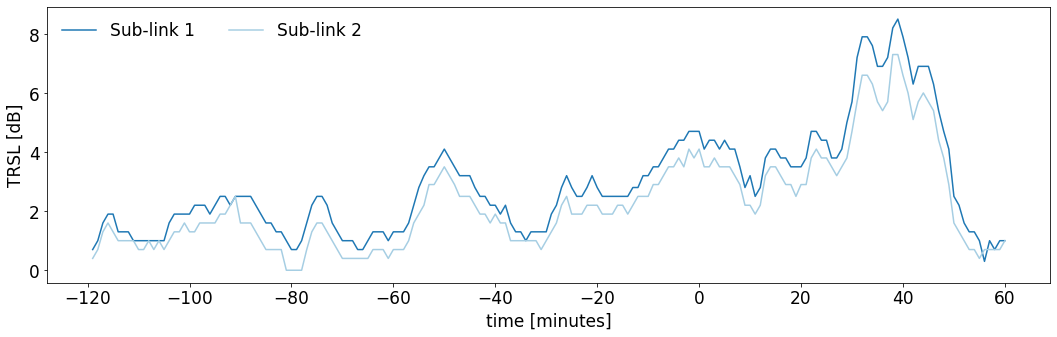

In [18]:
fig, ax = plt.subplots(1,1, figsize=(15,5),frameon=False)
ax.plot(np.arange(-119,61,1), X_test[rainratetest>4][3,:,0], color=blue, label='Sub-link 1')
ax.plot(np.arange(-119,61,1), X_test[rainratetest>4][3,:,1], color=lblue, label='Sub-link 2')
plt.xticks(np.arange(-120,61,20))
plt.ylabel('TRSL [dB]')
plt.xlabel('time [minutes]')
plt.legend(loc='upper left', ncol=2, frameon=False)
plt.tight_layout()
plt.show()

In [19]:
print('CNN scores')
cm = confusion_matrix(y_test, y_pred_t>threshold_cnn)
tot_pop1 = np.sum(cm[0,:])
tot_pop2 = np.sum(cm[1,:])
print('TNR:', (cm[0,0]/tot_pop1).round(decimals=2))
print('TPR:', (cm[1,1]/tot_pop2).round(decimals=2))
print('MCC:', matthews_corrcoef(y_test, np.ravel(y_pred_t)>threshold_cnn).round(decimals=2))
print('ACC:', accuracy_score(y_test, np.ravel(y_pred_t)>threshold_cnn).round(decimals=2))
print('F1:', f1_score(y_test, np.ravel(y_pred_t)>threshold_cnn).round(decimals=2))
print('A:',np.round(roc_surface(roc_cnn), decimals=2))

print('Q80 scores')
cm = confusion_matrix(y_test, y_pred_q802)
tot_pop1 = np.sum(cm[0,:])
tot_pop2 = np.sum(cm[1,:])
print('TNR:', (cm[0,0]/tot_pop1).round(decimals=2))
print('TPR:', (cm[1,1]/tot_pop2).round(decimals=2))
print('MCC:', matthews_corrcoef(y_test, y_pred_q802).round(decimals=2))
print('ACC:', accuracy_score(y_test, y_pred_q802).round(decimals=2))
print('F1:', f1_score(y_test, y_pred_q802).round(decimals=2))
print('A:',np.round(roc_surface(roc_q80), decimals=2))

print('OPT scores')
cm = confusion_matrix(y_test, y_std_max)
tot_pop1 = np.sum(cm[0,:])
tot_pop2 = np.sum(cm[1,:])
print('TNR:', (cm[0,0]/tot_pop1).round(decimals=2))
print('TPR:', (cm[1,1]/tot_pop2).round(decimals=2))
print('MCC:', matthews_corrcoef(y_test, y_std_max).round(decimals=2))
print('ACC:', accuracy_score(y_test, y_std_max).round(decimals=2))
print('F1:', f1_score(y_test, y_std_max).round(decimals=2))
print('A:',np.round(roc_surface(roc_opt), decimals=2))

CNN scores
TNR: 0.92
TPR: 0.86
MCC: 0.53
ACC: 0.92
F1: 0.52
A: 0.95
Q80 scores
TNR: 0.77
TPR: 0.86
MCC: 0.33
ACC: 0.78
F1: 0.29
A: 0.88
OPT scores
TNR: 0.93
TPR: 0.7
MCC: 0.45
ACC: 0.91
F1: 0.46
A: 0.85


### Plot normalized confusion matrices

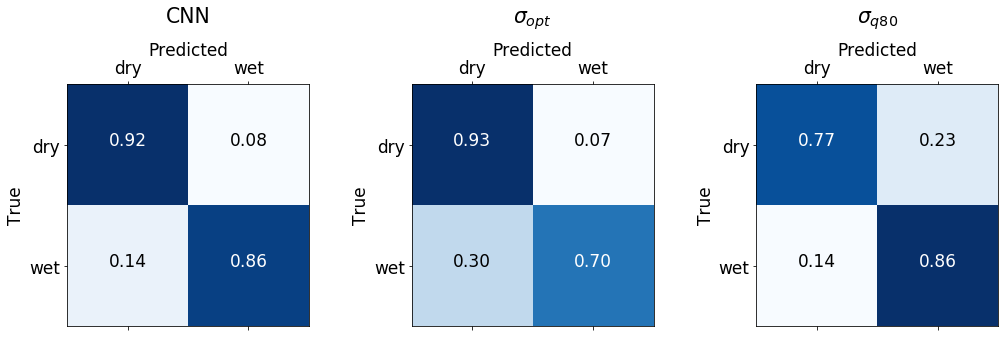

In [20]:
labels = ['dry', 'wet']

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(131)
cnf_matrix = confusion_matrix(y_test, y_pred_t>threshold_cnn)
cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
cax = ax1.matshow(cm, cmap=plt.cm.Blues)
ax1.set_xticklabels([''] + labels)
ax1.set_yticklabels([''] + labels)
fmt = '.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.xlabel('Predicted')
plt.ylabel('True')
ax1.xaxis.set_label_position('top') 
plt.tight_layout()
plt.title('CNN', pad=50)


ax2 = fig.add_subplot(132)
cnf_matrix = confusion_matrix(y_test, y_std_max)
cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
cax = ax2.matshow(cm, cmap=plt.cm.Blues)
ax2.set_xticklabels([''] + labels)
ax2.set_yticklabels([''] + labels)
fmt = '.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.xlabel('Predicted')
plt.ylabel('True')
ax2.xaxis.set_label_position('top') 
plt.tight_layout()
plt.title('$\sigma_{opt}$', pad=50)


ax3 = fig.add_subplot(133)
cnf_matrix = confusion_matrix(y_test, y_pred_q802)
cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
cax = ax3.matshow(cm, cmap=plt.cm.Blues)
ax3.set_xticklabels([''] + labels)
ax3.set_yticklabels([''] + labels)
fmt = '.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.xlabel('Predicted')
plt.ylabel('True')
ax3.xaxis.set_label_position('top') 
plt.tight_layout()
plt.title('$\sigma_{q80}$', pad=50)
plt.show()

### Plot ROC curves

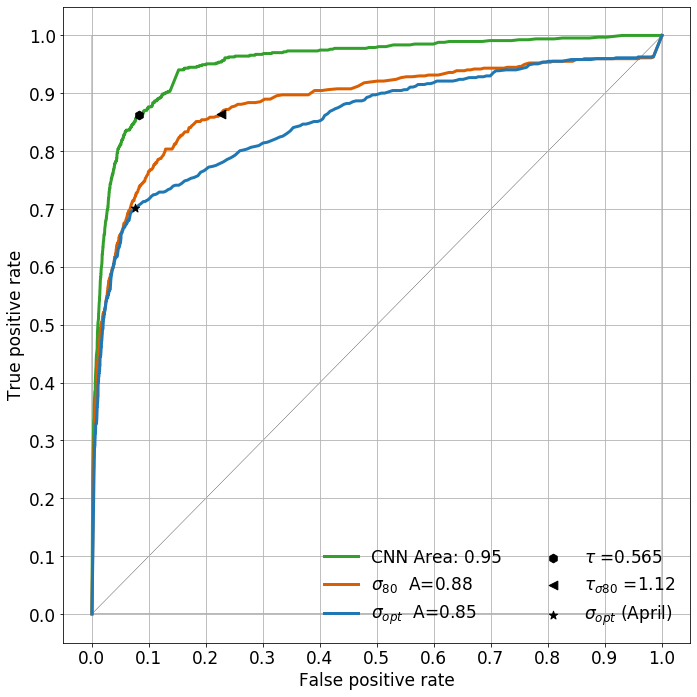

In [21]:
plt.figure(figsize=(10,10))
plt.plot(roc_cnn[:,1],roc_cnn[:,0], color=green, label='CNN Area: '+str(np.round(roc_surface(roc_cnn), decimals=2)), zorder=2, lw=3)
plt.scatter(roc_cnn[int(threshold_cnn*1000),1],roc_cnn[int(threshold_cnn*1000),0], color='black', marker='h', s=75, label='$\\tau$ ='+str(threshold_cnn), zorder=3)
plt.plot(roc_q80[:,1],roc_q80[:,0], color=orange, label='$\sigma_{80}$  A='+str(np.round(roc_surface(roc_q80), decimals=2)), zorder=2, lw=3)
plt.scatter(roc_q80[224,1],roc_q80[224,0], color='black', marker='<', s=75, label='$\\tau_{\sigma 80}$ =1.12', zorder=3)
plt.plot(roc_opt[:,1],roc_opt[:,0], color=blue, label='$\sigma_{opt}$  A='+str(np.round(roc_surface(roc_opt), decimals=2)), zorder=2, lw=3)
plt.scatter(roc_opt[200,1],roc_opt[200,0], color='black', marker='*', s=75, label='$\sigma_{opt}$ (April)', zorder=3)
plt.plot([0,0,1,0,1,1],[0,1,1,0,0,1], 'k-', linewidth=0.3, zorder=1)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right', ncol=2, frameon=False)
plt.grid()
plt.yticks(np.arange(0, 1.01, 0.1))
plt.xticks(np.arange(0, 1.01, 0.1))
plt.tight_layout()
plt.show()

### Plot the accuracy per rain rate

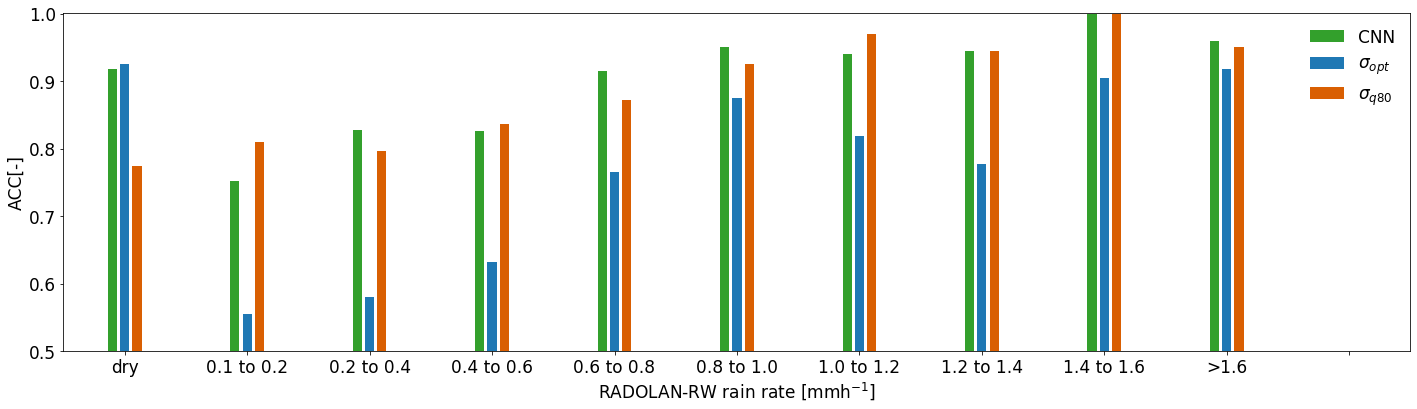

In [22]:
fig, ax = plt.subplots(figsize=(20,6))
ax.bar(scores_on_rainrates_cnn[:,0]-0.02,scores_on_rainrates_cnn[:,1], color=green, width=0.015, label='CNN')
ax.bar(scores_on_rainrates_opt[:,0]+0.00,scores_on_rainrates_opt[:,1], color=blue, width=0.015, label='$\sigma_{opt}$')
ax.bar(scores_on_rainrates_std_q802[:,0]+0.02,scores_on_rainrates_std_q802[:,1], color=orange, width=0.015, label='$\sigma_{q80}$')

# Set up grid, legend, and limits
plt.grid(True)
plt.xticks(np.arange(0, 2.1, 0.2))
plt.yticks(np.arange(0, 1.001, 0.1))
ax.set_xlim(-0.1, 2.1);
ax.set_ylim(0.5, 1.001);
ax.xaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
plt.ylabel('ACC[-]')
plt.xlabel('RADOLAN-RW rain rate [mmh$^{-1}$]')
plt.legend(loc='upper right', frameon=False)
plt.grid()
plt.tight_layout()
plt.show()

### Plot the individual MCC scores

/home/polz-j/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 1152x576 with 0 Axes>

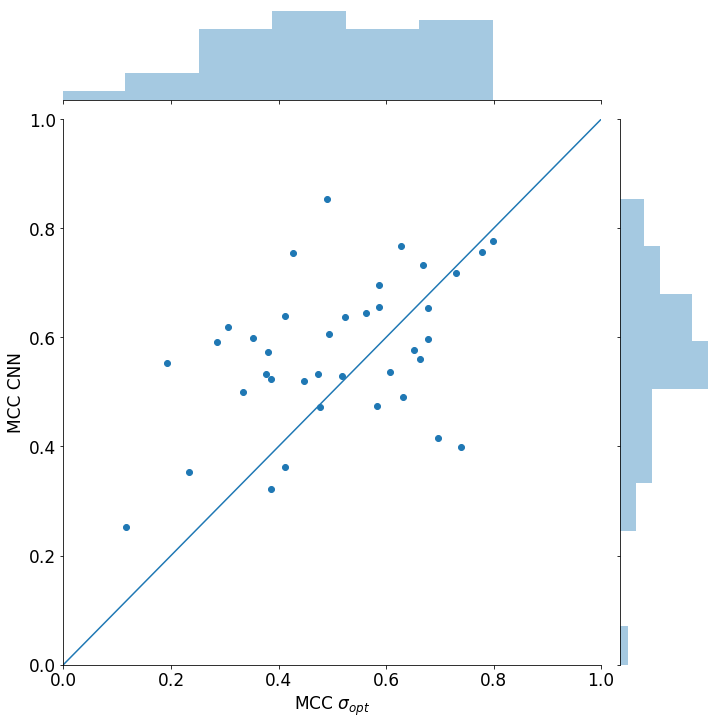

In [23]:
fig = plt.figure(figsize=(16,8))
g = sns.jointplot(comp[0,:],comp[1,:], kind='scatter', color=blue, xlim=[0,1], ylim=[0,1], height=10).set_axis_labels('MCC $\sigma_{opt}$', 'MCC CNN')
g.fig.get_children()[1].plot([0, 1], [0, 1], color=blue)
plt.show()

### Plot the full time series with predictions

In [24]:
cml_plot_list = ['SY0208_2_SY2031_3', 'SY1000_2_SY2704_2', 'HY1309_2_HY8929_2', 'SY1468_2_SY2609_3'] #list of CML ids you want to plot

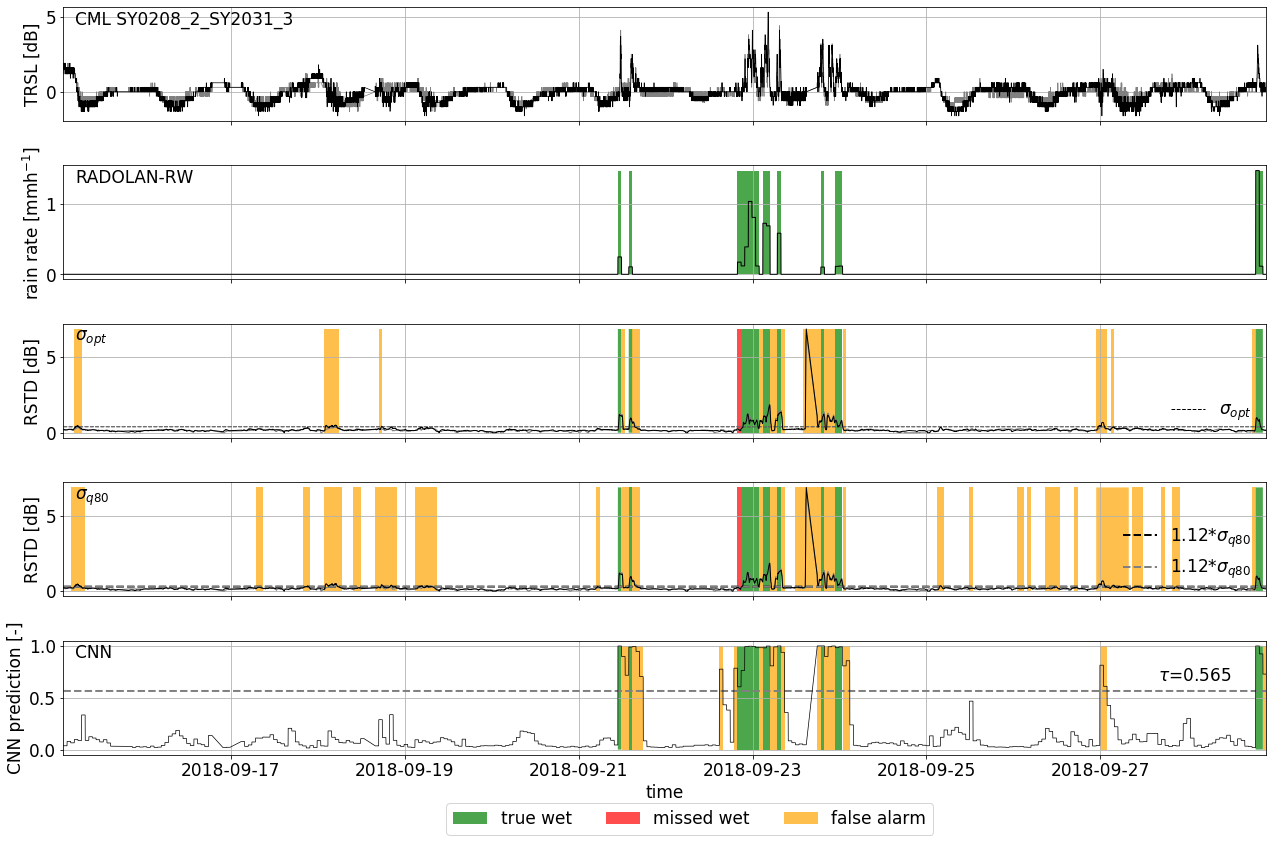

cnn MCC: 0.64  ACC: 0.94   std opt MCC: 0.56  ACC: 0.92   std q80 MCC: 0.35  ACC: 0.77


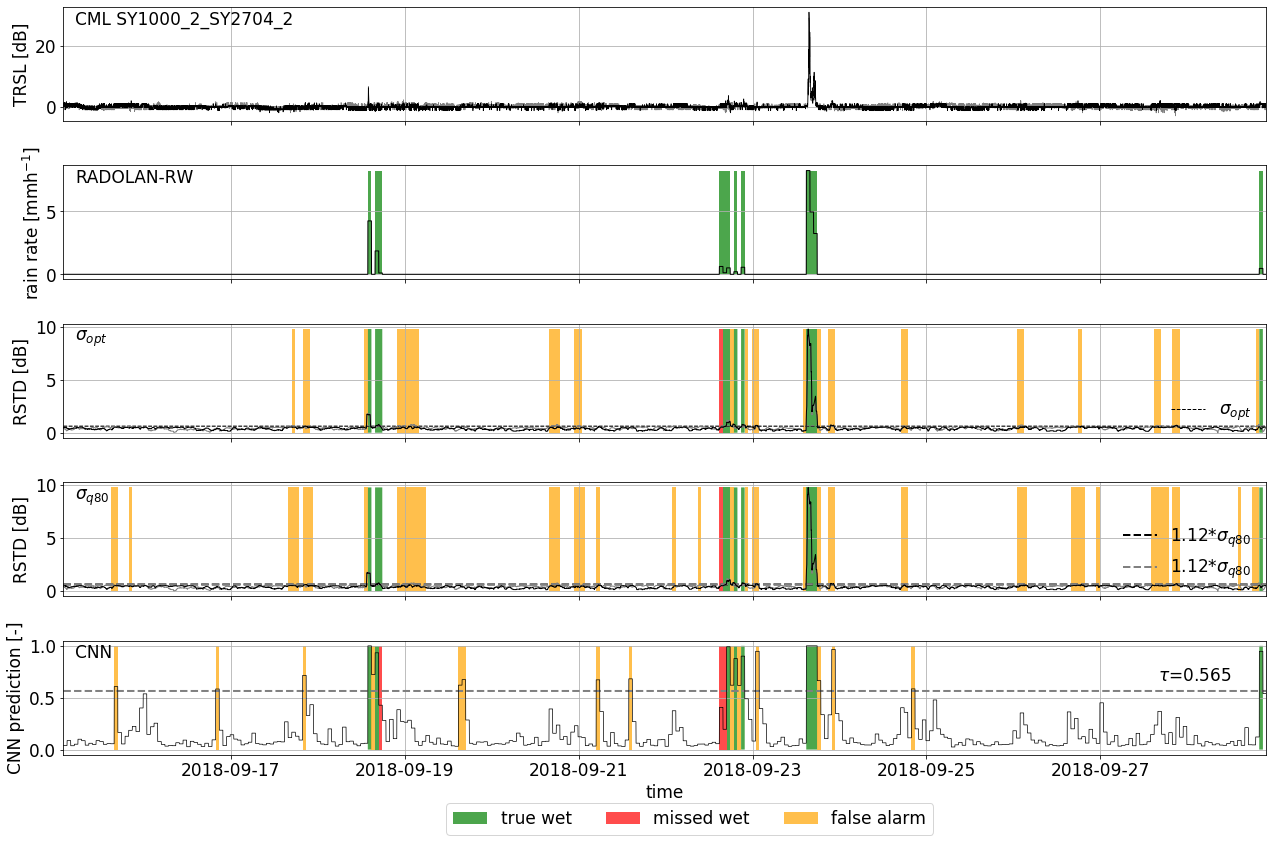

cnn MCC: 0.52  ACC: 0.95   std opt MCC: 0.45  ACC: 0.9   std q80 MCC: 0.35  ACC: 0.83


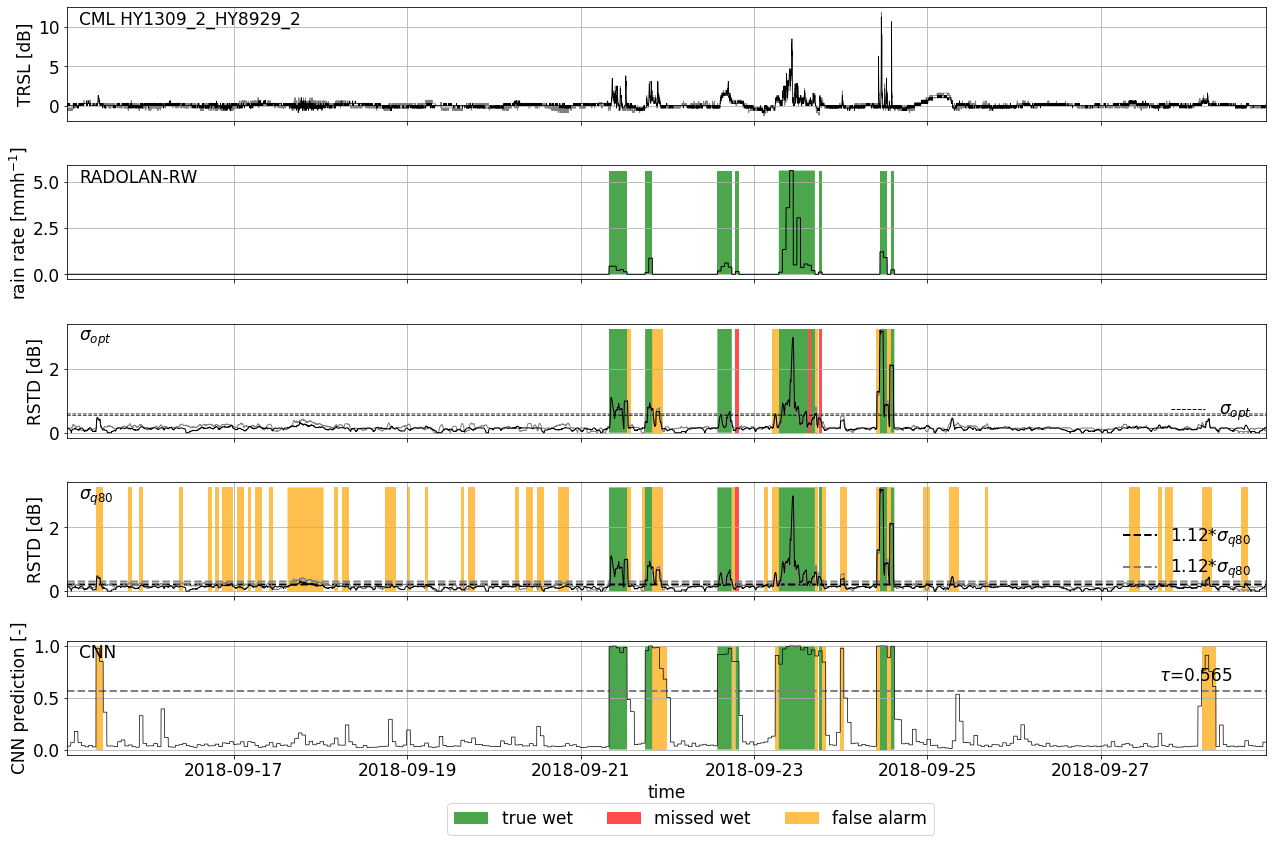

cnn MCC: 0.76  ACC: 0.95   std opt MCC: 0.78  ACC: 0.96   std q80 MCC: 0.41  ACC: 0.77


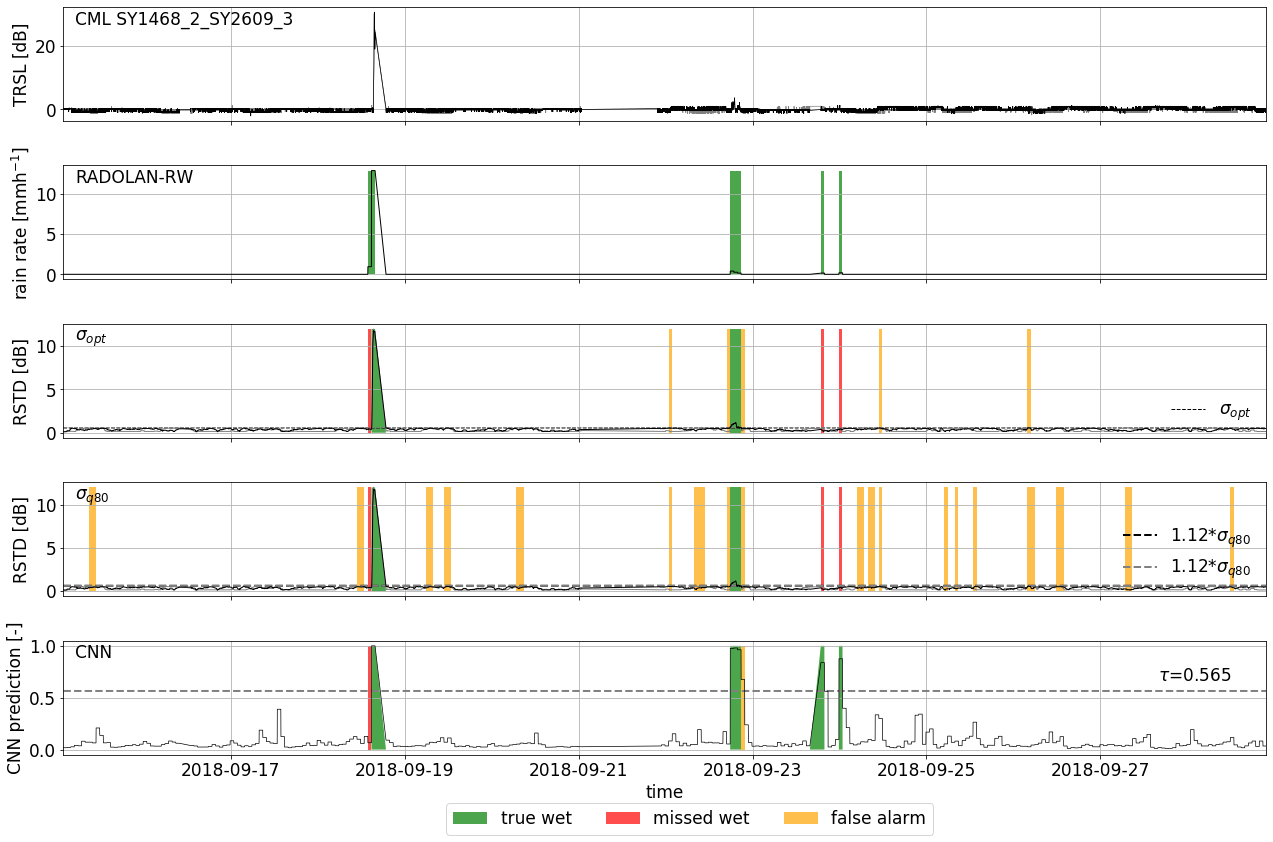

cnn MCC: 0.85  ACC: 0.99   std opt MCC: 0.49  ACC: 0.97   std q80 MCC: 0.22  ACC: 0.89


In [25]:
for cml_name in cml_plot_list:
    data1_fts=[]
    data2_fts=[]
    ref_fts=[]
    timestamp_fts=[]
    rr_rad_fts=[]
    stddev1_fts=[]
    stddev2_fts=[]
    st1_opt_fts=thresh_jul_list_1[id_list_test==cml_name][0]
    st2_opt_fts=thresh_jul_list_2[id_list_test==cml_name][0]
    q801_fts=threshold_q8012[id_list_test==cml_name][0]
    q802_fts=threshold_q8022[id_list_test==cml_name][0]
    cnn_pred_fts=[]
    y_sop_fts=[]
    y_q80_fts=[]
    for timestamp in starting_time_test[id_list_test==cml_name]:
        data1_fts.append(X_test[id_list_test==cml_name][starting_time_test[id_list_test==cml_name]==timestamp][0,120:,0])
        data2_fts.append(X_test[id_list_test==cml_name][starting_time_test[id_list_test==cml_name]==timestamp][0,120:,1])
        stddev1_fts.append(rstd_test[id_list_test==cml_name][starting_time_test[id_list_test==cml_name]==timestamp][0,:,0])
        stddev2_fts.append(rstd_test[id_list_test==cml_name][starting_time_test[id_list_test==cml_name]==timestamp][0,:,1])
        ref_fts.append(np.repeat(y_test[id_list_test==cml_name][starting_time_test[id_list_test==cml_name]==timestamp],60))
        cnn_pred_fts.append(np.repeat(y_pred_t[id_list_test==cml_name][starting_time_test[id_list_test==cml_name]==timestamp],60))
        y_sop_fts.append(np.repeat(y_std_max[id_list_test==cml_name][starting_time_test[id_list_test==cml_name]==timestamp],60))
        y_q80_fts.append(np.repeat(y_pred_q802[id_list_test==cml_name][starting_time_test[id_list_test==cml_name]==timestamp],60))
        rr_rad_fts.append(np.repeat(rainratetest[id_list_test==cml_name][starting_time_test[id_list_test==cml_name]==timestamp],60))
        timestamp_fts.append(pd.date_range(pd.Timestamp(timestamp), freq='min', periods=60))
    dims=len(data1_fts)*60
    data1_fts=np.reshape(np.array(data1_fts), (dims))
    data2_fts=np.reshape(np.array(data2_fts), (dims))
    ref_fts=np.reshape(np.array(ref_fts), (dims))
    cnn_pred_fts=np.reshape(np.array(cnn_pred_fts), (dims))
    y_sop_fts=np.reshape(np.array(y_sop_fts), (dims))
    y_q80_fts=np.reshape(np.array(y_q80_fts), (dims))
    stddev1_fts=np.reshape(np.array(stddev1_fts), (dims))
    stddev2_fts=np.reshape(np.array(stddev2_fts), (dims))
    rr_rad_fts=np.reshape(np.array(rr_rad_fts), (dims))
    timestamp_fts=np.reshape(np.array(timestamp_fts), (dims))

    # %matplotlib widget
    st=0 ##st paper
    en=dims-1
    no_m=data1_fts[st:en]!=-9999
    fig=plt.figure(figsize=(18,12))

    timex=timestamp_fts[st:en][no_m]
    ch1=data1_fts[st:en][no_m]
    ch2=data2_fts[st:en][no_m]
    y=ref_fts[st:en][no_m]
    ycnn=cnn_pred_fts[st:en][no_m]>threshold_cnn
    s1=stddev1_fts[st:en][no_m]
    s2=stddev2_fts[st:en][no_m]
    ysop=y_sop_fts[st:en][no_m]
    ys80=y_q80_fts[st:en][no_m]


    ax1 = fig.add_subplot(511)
    ax1.plot(timex, ch2, color='gray', lw=0.7)
    ax1.plot(timex, ch1, color='black', lw=0.7)
    ax1.text(0.01,0.85,'CML '+str(cml_name), transform=ax1.transAxes)
    # ax1.legend()
    plt.ylabel('TRSL [dB]')
    plt.setp(ax1.get_xticklabels(), visible=False)
    # plt.title('a)')
    plt.grid()



    ax2 = fig.add_subplot(514, sharex=ax1)
    # ax2.plot(timex, np.logical_or(stddev1_fts[st:en][no_m]>1.12*q801_fts, stddev2_fts[st:en][no_m]>1.12*q802_fts), label='Stdev q80')
    # ax2.plot(timex, np.repeat(1.12*q801_fts,en-st)[no_m], label='q801')
    # ax2.plot(timex, np.repeat(1.12*q802_fts,en-st)[no_m], label='q802')
    ax2.plot(timex, np.repeat(1.12*q801_fts, len(timex)), color='black', linestyle='--', lw=2, label='1.12*$\sigma_{q80}$')
    ax2.plot(timex, np.repeat(1.12*q802_fts, len(timex)), color='gray', linestyle='--', lw=2, label='1.12*$\sigma_{q80}$')
    sq80=s1.copy()
    sq80[sq80<1.12*q801_fts]=1.12*q801_fts
    ax2.plot(timex, s2, color='grey', lw=1)
    ax2.plot(timex, s1, color='black', lw=1)
    # ax2.plot(timex, stddev2_fts[st:en][no_m], label='std2')
    ax2.fill_between(timex, 0, np.max([np.max(s2),np.max(s1)])*ys80, where=ys80 ==y, facecolor='green', alpha=0.7)
    ax2.fill_between(timex, 0, np.max([np.max(s2),np.max(s1)]), where=ys80<y, facecolor='red', alpha=0.7)
    ax2.fill_between(timex, 0, np.max([np.max(s2),np.max(s1)]), where=ys80>y, facecolor='orange', alpha=0.7)
    # plt.text(0,0,'$\sigma_{q80}$')
    ax2.legend(loc='lower right', frameon=False)
    ax2.text(0.01,0.85,'$\sigma_{q80}$', transform=ax2.transAxes)
    plt.setp(ax2.get_xticklabels(), visible=False)
    # plt.title('d)')
    plt.ylabel('RSTD [dB]')
    plt.grid()



    ax5 = fig.add_subplot(513, sharex=ax1)
    # ax5.plot(timex, ysop, label='Stdev opt')
    # ax2.plot(timex, np.repeat(st1_opt_fts,en-st)[no_m], label='opt1')
    # ax2.plot(timex, np.repeat(st2_opt_fts,en-st)[no_m], label='opt2')
    ax5.plot(timex, np.repeat(st1_opt_fts, len(timex)), color='black', linestyle='--', lw=1, label='$\sigma_{opt}$')
    ax5.plot(timex, np.repeat(st2_opt_fts, len(timex)), color='gray', linestyle='--', lw=1)
    ax5.legend(loc='lower right', frameon=False)
    sopt=s1.copy()
    sopt[sopt<st1_opt_fts]=st1_opt_fts
    ax5.plot(timex, s2, color='grey', lw=1)
    ax5.plot(timex, s1, color='black', lw=1)
    # ax5.plot(timex, s2, label='std2')
    ax5.fill_between(timex, 0, np.max([np.max(s2),np.max(s1)])*ysop, where=ysop==y, facecolor='green', alpha=0.7)
    ax5.fill_between(timex, 0, np.max([np.max(s2),np.max(s1)]), where=ysop<y, facecolor='red', alpha=0.7)
    ax5.fill_between(timex, 0, np.max([np.max(s2),np.max(s1)]), where=ysop>y, facecolor='orange', alpha=0.7)
    ax5.text(0.01,0.85,'$\sigma_{opt}$', transform=ax5.transAxes)
    plt.setp(ax5.get_xticklabels(), visible=False)
    # plt.title('e)')
    plt.ylabel('RSTD [dB]')
    plt.grid()



    ax3 = fig.add_subplot(512, sharex=ax1)
    ax3.plot(timex, rr_rad_fts[st:en][no_m], color='black', lw=1)
    # ax3.plot(timex, ref_fts[st:en][no_m], label='ref')
    ax3.fill_between(timex, 0, np.max(rr_rad_fts[st:en][no_m]), where=y==1, facecolor='green', alpha=0.7)
    plt.setp(ax3.get_xticklabels(), visible=False)
    ax3.text(0.01,0.85,'RADOLAN-RW', transform=ax3.transAxes)
    # plt.title('b)')
    plt.ylabel('rain rate [mmh$^{-1}$]')
    plt.grid()


    ax4 = fig.add_subplot(515, sharex=ax1)
    # ax4.plot(timex, ycnn, label='cnn classification')
    # ax4.plot(timex, np.repeat(threshold_cnn,en-st)[no_m], label='cnn threshold')
    ax4.plot(timex, np.repeat(threshold_cnn, len(timex)), color='gray', linestyle='--', lw=2)
    ax4.plot(timex, cnn_pred_fts[st:en][no_m], color='black', lw=0.7)
    ax4.fill_between(timex, 0, ycnn, where=ycnn==y, facecolor='green', alpha=0.7, label='true wet')
    ax4.fill_between(timex, 0, 1, where=ycnn<y, facecolor='red', alpha=0.7, label='missed wet')
    ax4.fill_between(timex, 0, 1, where=ycnn>y, facecolor='orange', alpha=0.7, label='false alarm')
    # ax4.legend()
    plt.xlim(timestamp_fts[st],timestamp_fts[en])
    ax4.legend(bbox_to_anchor=(0.73,-0.35), ncol=3)
    ax4.text(0.01,0.85,'CNN', transform=ax4.transAxes)
    ax4.text(0.91,0.65,'$\\tau$=0.565', transform=ax4.transAxes)
    plt.xlabel('time')
    # plt.title('c)')
    plt.ylabel('CNN prediction [-]')
    plt.grid()
    plt.tight_layout()
    plt.show()
    print('cnn MCC:' , str(np.round(matthews_corrcoef(y, ycnn), decimals=2)), ' ACC:' , str(np.round(accuracy_score(y, ycnn), decimals=2)), 
          '  std opt MCC:' , str(np.round(matthews_corrcoef(y, ysop), decimals=2)),' ACC:' , str(np.round(accuracy_score(y, ysop), decimals=2)),
          '  std q80 MCC:' , str(np.round(matthews_corrcoef(y, ys80), decimals=2)),' ACC:' , str(np.round(accuracy_score(y, ys80), decimals=2))
         )